In [1]:
import sys
!pip install --prefix {sys.prefix} pandas tensorflow scikit-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(3)

df = pd.read_csv('/content/drive/MyDrive/minor_project/GEFCom2014-E - Hourly.csv',parse_dates=True)
load = pd.DataFrame(data=df,columns=['load'])

load.ffill(inplace=True)
load["load"]=load["load"].astype(float).astype(int)

print(load)

       load
0      3010
1      2853
2      2758
3      2705
4      2709
...     ...
78883  4012
78884  3856
78885  3671
78886  3499
78887  3345

[78888 rows x 1 columns]


In [4]:
df.head()

,Date,Hour,load,T
0,1/1/2006,1,3010.0,22.67
1,1/1/2006,2,2853.0,20.67
2,1/1/2006,3,2758.0,21.33
3,1/1/2006,4,2705.0,19.00
4,1/1/2006,5,2709.0,19.33


In [5]:
df.index

RangeIndex(start=0, stop=78888, step=1)

In [6]:
df.index = pd.date_range(start='2006-01-01', periods=len(df), freq='H')
df.head()

,Date,Hour,load,T
2006-01-01 00:00:00,1/1/2006,1,3010.0,22.67
2006-01-01 01:00:00,1/1/2006,2,2853.0,20.67
2006-01-01 02:00:00,1/1/2006,3,2758.0,21.33
2006-01-01 03:00:00,1/1/2006,4,2705.0,19.00
2006-01-01 04:00:00,1/1/2006,5,2709.0,19.33


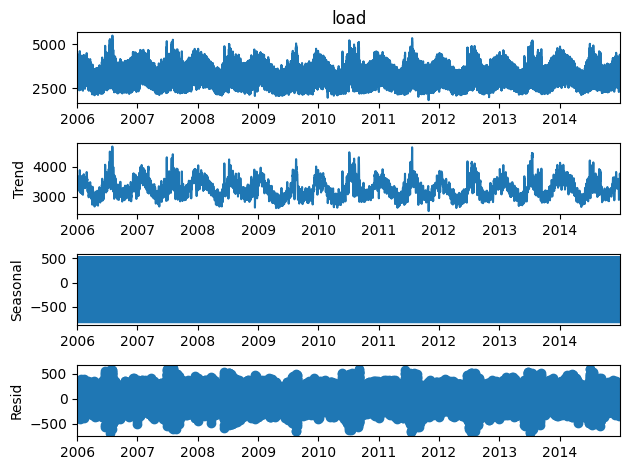

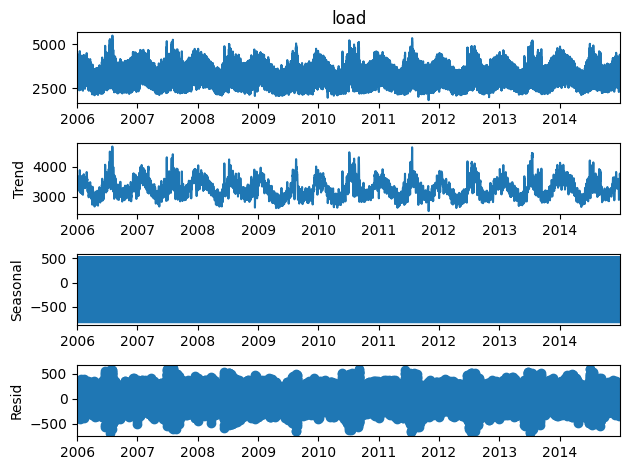

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df['load'])
results.plot()

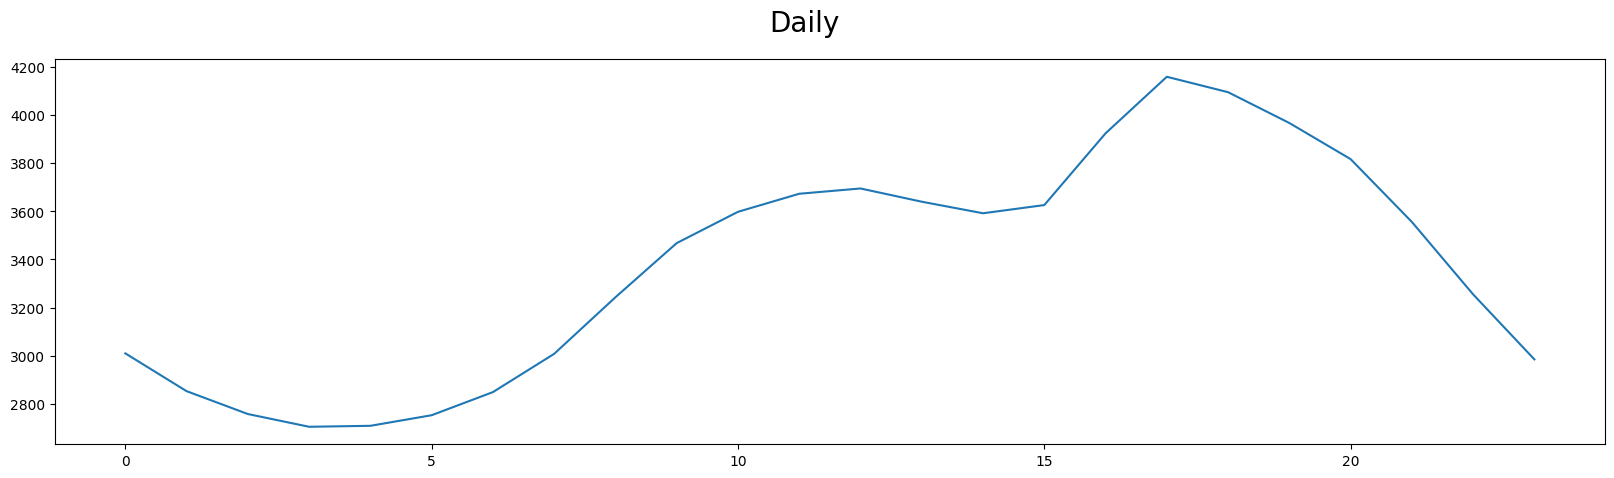

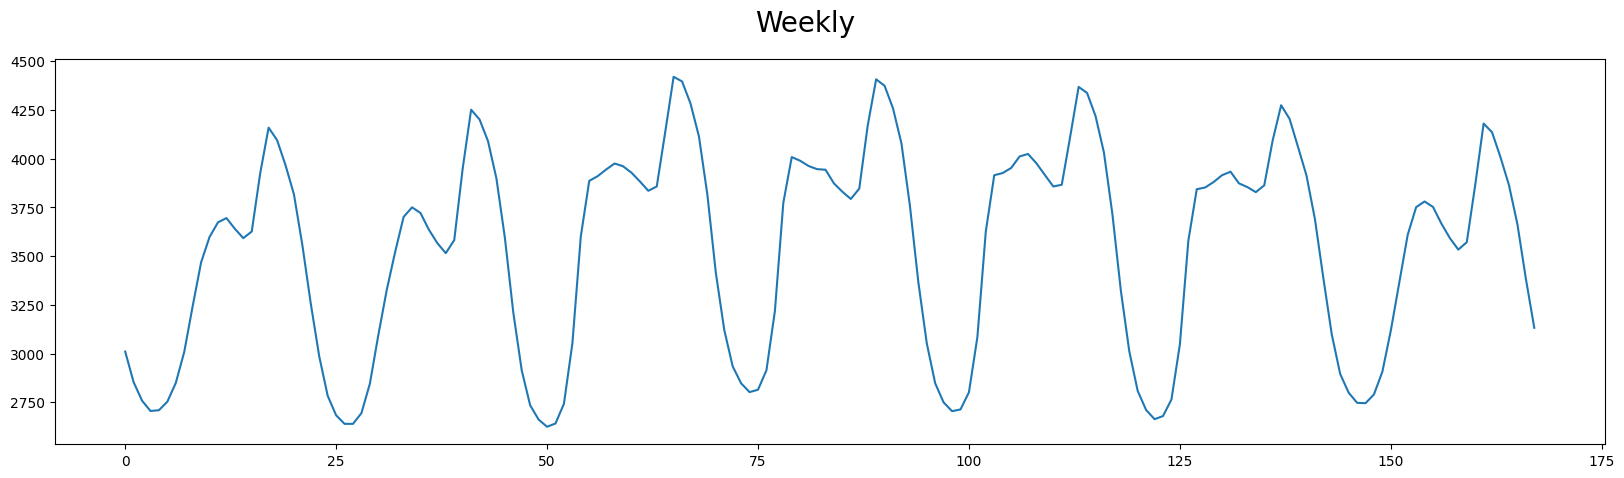

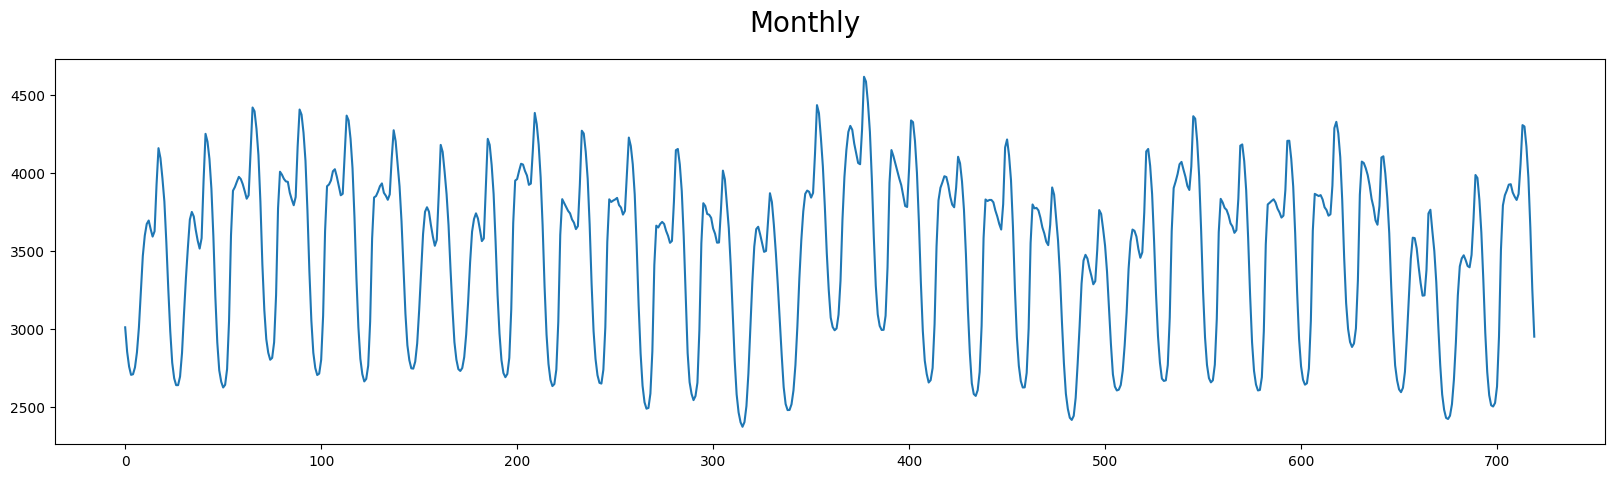

In [8]:
plt.figure (figsize=(20,5)).suptitle("Daily", fontsize=20) 
plt.plot(load["load"].head (24))
plt.show()

plt.figure (figsize=(20,5)).suptitle("Weekly", fontsize=20) 
plt.plot(load["load"].head (168))
plt.show()

plt.figure (figsize=(20,5)).suptitle("Monthly", fontsize=20) 
plt.plot(load["load"].head (720))
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


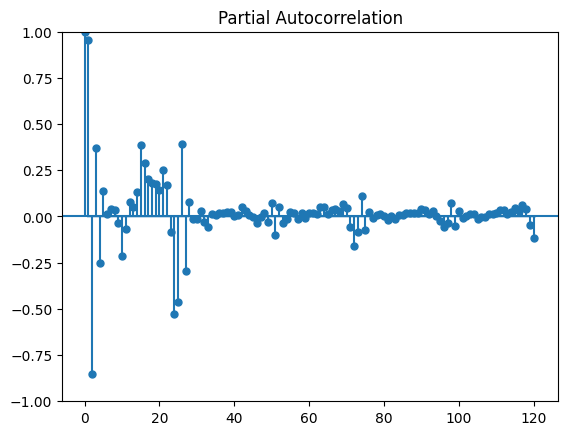

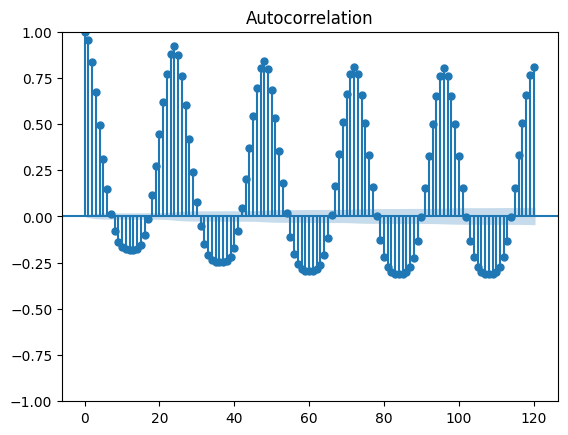

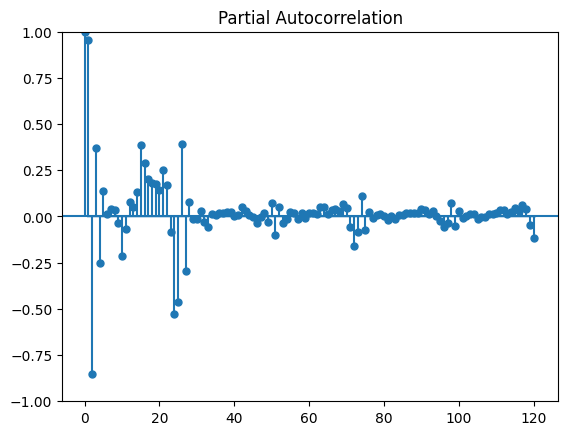

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['load'], lags=120)
plot_pacf(df['load'], lags=120)

In [10]:
from statsmodels.tsa.stattools import adfuller

# assume time_series is your single variable time series data
result = adfuller(load)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -16.428430
p-value: 0.000000


In [11]:
from sklearn.preprocessing import StandardScaler

print("LOAD range before scaling :",
        min(load.load),
        max(load.load))

scaler = StandardScaler()
scaled_load=scaler.fit_transform(load)
print("LOAD range after scaling :",
        min(scaled_load),
        max(scaled_load))

train_size =  int(len(load) * 0.67)
test_size = len(load) - train_size -720

lookback = 720

train_load=scaled_load[0:train_size,:]
test_load=scaled_load[train_size-lookback:train_size+test_size,:]



print("\n Shape of Train, Test : ",
      train_load.shape, test_load.shape)


LOAD range before scaling : 1811 5506
LOAD range after scaling : [-2.58192885] [3.79096495]

 Shape of Train, Test :  (52854, 1) (26034, 1)


In [28]:
future_one_day=scaled_load[-24:,:]
future_one_month=scaled_load[-720:,:]

In [12]:
#Prepare RNN Dataset.

def create_rnn_dataset (data, lookback=1):
  data_x, data_y = [], []
  for i in range(len(data)-lookback-1):
    a = data[i: (i+ lookback), 0]
    data_x.append(a)
    data_y.append(data[i+ lookback, 0])
  return np.array(data_x), np.array(data_y)

#create X and Y for training

train_load_x, train_load_y= create_rnn_dataset(train_load,lookback)
test_load_x, test_load_y= create_rnn_dataset(test_load,lookback)

#Reshape for use with LSTM

train_load_x = np.reshape(train_load_x,(train_load_x.shape[0], 1, train_load_x.shape[1]))
test_load_x = np.reshape(test_load_x,(test_load_x.shape[0], 1, test_load_x.shape[1]))

print ("Shapes of X, Y train: ", train_load_x.shape, train_load_y.shape)
print ("Shapes of X, Y test: ", test_load_x.shape, test_load_y.shape)

# print(train_load_x)
# print(train_load_y)

Shapes of X, Y train:  (52133, 1, 720) (52133,)
Shapes of X, Y test:  (25313, 1, 720) (25313,)


In [13]:
#@title Default title text
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM,Dense,Activation,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

tf.random.set_seed(3)
ts_model=Sequential()

ts_model.add(LSTM(256,return_sequences=True,input_shape=(1,lookback)))
ts_model.add(Dropout(0.0))

#ts_model.add(LSTM(24,return_sequences=True,input_shape=(1,lookback)),kernel_regularizer=regularizers.l2(0.001))
#ts_model.add(Dropout(0.1))

ts_model.add(LSTM(256,return_sequences=False))
ts_model.add(Dropout(0.0))

ts_model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
ts_model.add(Dense(1))

ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])
ts_model.summary()

filepath = 'model/{epoch:02d}.hdf5'
callbacks = [EarlyStopping(monitor='val_loss',patience=10),
             ModelCheckpoint(filepath,monitor='loss',mode='min')]

ts_model.fit(train_load_x, train_load_y, validation_split=0.1, epochs=100, callbacks=callbacks, batch_size=120, verbose=1)

print("-----END-----")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            1000448   
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,591,809
Trainable params: 1,591,809
Non-

In [14]:
#ts_model.load_weights('/content/model/55.hdf5')
# ts_model.evaluate(test_load_x, test_load_y, verbose=1)

predict_on_train=ts_model.predict(train_load_x)
predict_on_test=ts_model.predict(test_load_x)

792/792 [==============================] - 6s 8ms/step


In [15]:
predict_on_train=scaler.inverse_transform(predict_on_train)
predict_on_test=scaler.inverse_transform(predict_on_test)

In [16]:
test_load_y = scaler.inverse_transform([test_load_y])
train_load_y = scaler.inverse_transform([train_load_y])

In [17]:
print(test_load_y[0][:24])
print(train_load_y[0][:24])
print(predict_on_train[:24,0])

[3403. 3675. 3769. 3844. 3928. 3977. 3956. 3928. 3875. 3834. 4020. 4251.
 4207. 4057. 3844. 3527. 3192. 2924. 2747. 2665. 2629. 2633. 2715. 2971.]
[2768. 2676. 2633. 2648. 2747. 3040. 3580. 3850. 3909. 3932. 3975. 3990.
 3970. 3969. 3927. 3938. 4092. 4340. 4333. 4202. 4007. 3697. 3317. 2994.]
[2781.8955 2694.377  2666.832  2676.0603 2766.0793 3053.0823 3528.7476
 3780.434  3844.5173 3896.4675 3920.3528 3923.3838 3908.5447 3915.4958
 3914.0618 3923.521  4017.01   4279.133  4326.745  4191.855  4055.7139
 3727.5957 3300.9343 3013.1584]


In [18]:
from sklearn.metrics import mean_squared_error
import math

trainScore = math.sqrt(mean_squared_error(train_load_y[0], predict_on_train[:,0]))
print(trainScore)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(test_load_y[0], predict_on_test[:,0]))
print(testScore)
print('Test Score: %.2f RMSE' % (testScore))

# rmse_one_day = math.sqrt(mean_squared_error(test_load_y[0][:24], predict_on_test[:24,0]))
# print(rmse_one_day)

32.18724522492819
Train Score: 32.19 RMSE
47.92008735390547
Test Score: 47.92 RMSE


In [19]:
from sklearn.metrics import mean_absolute_error

mae_train=mean_absolute_error(train_load_y[0], predict_on_train[:,0])
mae_test=mean_absolute_error(test_load_y[0], predict_on_test[:,0])

print(mae_train)
print(mae_test)

24.046870082814028
37.47499923998415


In [20]:
from sklearn.metrics import mean_squared_error

nrmse_train=np.sqrt(mean_squared_error(train_load_y[0], predict_on_train[:,0])) / (train_load_y[0].max() - train_load_y[0].min())
nrmse_test=np.sqrt(mean_squared_error(test_load_y[0], predict_on_test[:,0])) / (test_load_y[0].max() - test_load_y[0].min())

print(nrmse_train)
print(nrmse_test)

0.008711027124473124
0.014767361280094137


In [21]:
from sklearn.metrics import r2_score

r2_train = r2_score(train_load_y[0], predict_on_train[:,0])
r2_test = r2_score(test_load_y[0], predict_on_test[:,0])

print(r2_train)
print(r2_test)

0.9969976790727461
0.9928189691229744


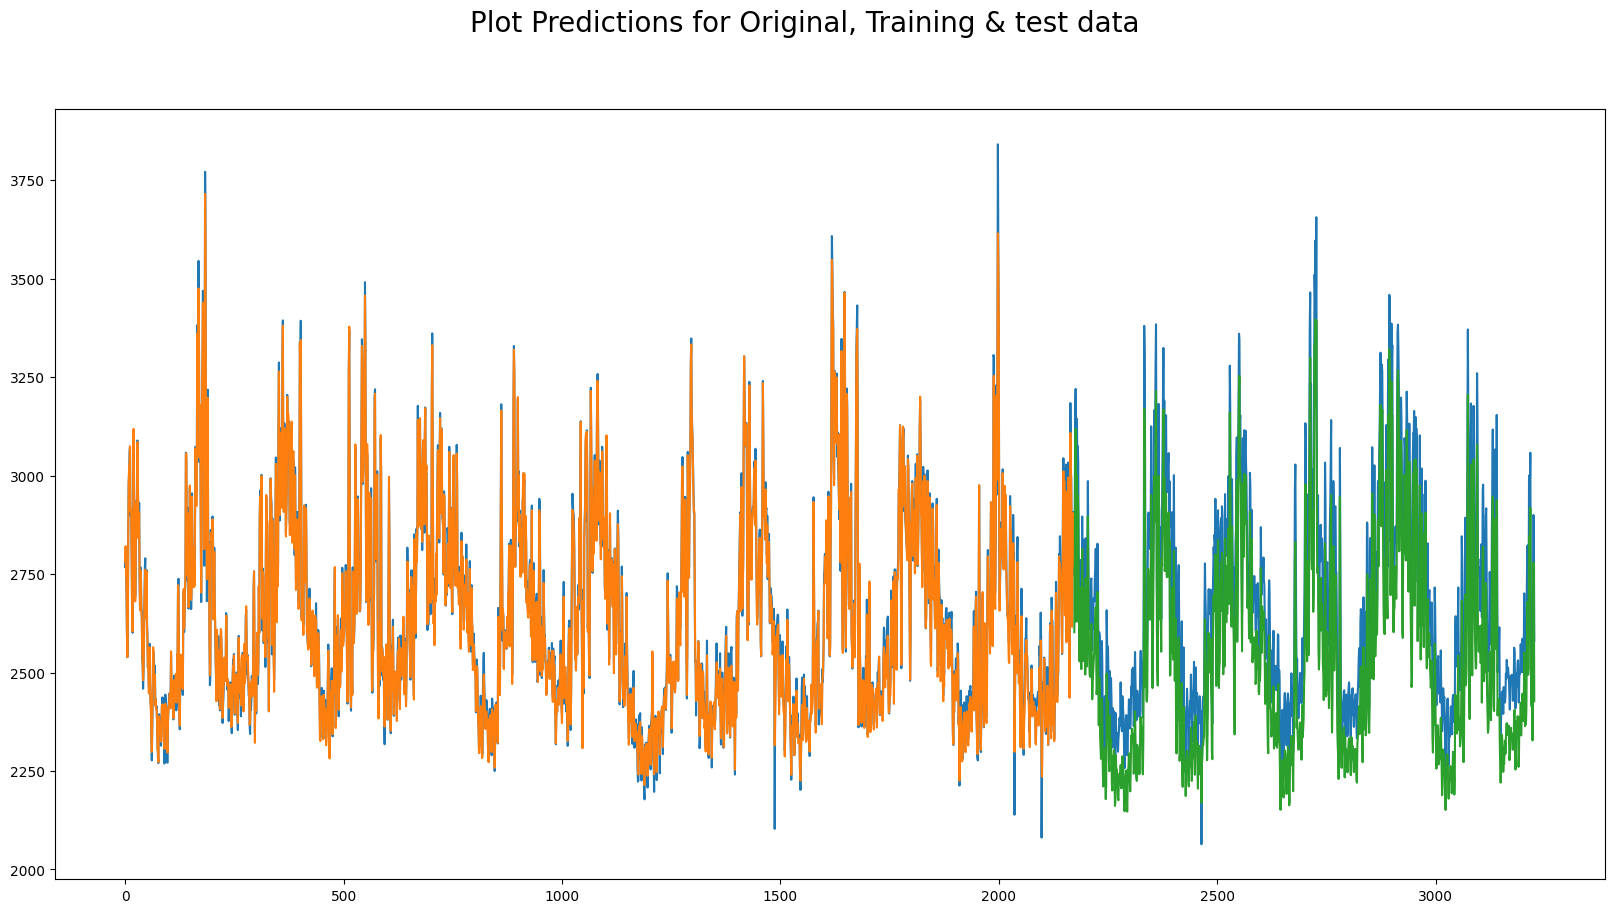

In [22]:
total_size=len(predict_on_train)+len(predict_on_test)

orig_data=load.load.to_numpy()
orig_data=orig_data[0:train_size+test_size]
orig_data=orig_data.reshape(len(orig_data),1)

orig_plot=np.empty((total_size,1))
orig_plot[:,:]=np.nan
orig_plot[0:total_size, :]=orig_data[lookback:-2, :]

predict_train_plot=np.empty((total_size,1))
predict_train_plot[:,:]=np.nan
predict_train_plot[0:len(predict_on_train),:]=predict_on_train

predict_test_plot=np.empty((total_size,1))
predict_test_plot[:,:]=np.nan
predict_test_plot[len(predict_on_train):total_size,:]=predict_on_test

plt.figure(figsize=(20, 10)).suptitle("Plot Predictions for Original, Training & test data", fontsize=20) 
plt.plot(orig_plot[::24])
plt.plot(predict_train_plot[::24])
plt.plot(predict_test_plot[::24])
plt.show()


In [38]:
curr_input=train_load_x[-1,:].flatten()

predict_for=24

for i in range(predict_for):
  this_input=curr_input[-lookback:]
  this_input=this_input.reshape((1,1,lookback))
  this_prediction=ts_model.predict(this_input,verbose=0)
  curr_input=np.append(curr_input,this_prediction.flatten())

predict_on_future_day=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))
predict_on_future_day=scaler.inverse_transform(predict_on_future_day)

print(predict_on_future_day)
print(len(predict_on_future_day))

[[2716.31906776]
 [2999.94224455]
 [3462.75914403]
 [3690.42077003]
 [3727.72264165]
 [3742.02950962]
 [3755.47710915]
 [3735.48190758]
 [3712.46616869]
 [3720.51296332]
 [3736.95310759]
 [3769.10496706]
 [4003.53181147]
 [4296.81294578]
 [4298.51883417]
 [4205.32898731]
 [4042.97950421]
 [3784.66704293]
 [3421.43018595]
 [3125.67862894]
 [2931.21784105]
 [2830.77387332]
 [2771.90175111]
 [2752.87581844]]
24


In [34]:
test_load = scaler.inverse_transform(test_load) 

In [39]:
future_rmse = np.sqrt(mean_squared_error(test_load[:24], predict_on_future_day))
print(future_rmse) 

future_mae = mean_absolute_error(test_load[:24], predict_on_future_day)
print(future_mae)

future_nrmse = np.sqrt(mean_squared_error(test_load[:24], predict_on_future_day)) / (test_load[:24].max() - test_load[:24].min())
print(future_nrmse)

future_r2 = r2_score(test_load[:24], predict_on_future_day)
print(future_r2)

460.889611533363
370.9205401612053
0.2829279383261897
0.2139724271991036


In [ ]:
# actual_load = scaled_load[train_size+test_size:]
# actual_load = scaler.inverse_transform(actual_load)

# print(len(actual_load))

In [ ]:
# print(actual_load[:24])

In [56]:
# future_rmse = np.sqrt(mean_squared_error(actual_load[:24], predict_on_future))
# print(future_rmse) 

# future_mae = mean_absolute_error(actual_load[:24], predict_on_future)
# print(future_mae)

# future_nrmse = np.sqrt(mean_squared_error(actual_load[:24], predict_on_future)) / (actual_load[:24].max() - actual_load[:24].min())
# print(future_nrmse)

# future_r2 = r2_score(actual_load[:24], predict_on_future)
# print(future_r2)

In [37]:
curr_input=test_load_x[-1,:].flatten()

predict_for=720

for i in range(predict_for):
  this_input=curr_input[-lookback:]
  this_input=this_input.reshape((1,1,lookback))
  this_prediction=ts_model.predict(this_input,verbose=0)
  curr_input=np.append(curr_input,this_prediction.flatten())

predict_on_future_month=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))
predict_on_future_month=scaler.inverse_transform(predict_on_future_month)

# print(predict_on_future)
print(len(predict_on_future_month))

720


In [40]:
print(predict_on_future_month[:10])

[[3202.77954334]
 [2901.8858363 ]
 [2703.70803158]
 [2570.59676081]
 [2486.73901713]
 [2443.28092117]
 [2494.0495033 ]
 [2752.46218492]
 [3168.39911186]
 [3442.77950253]]


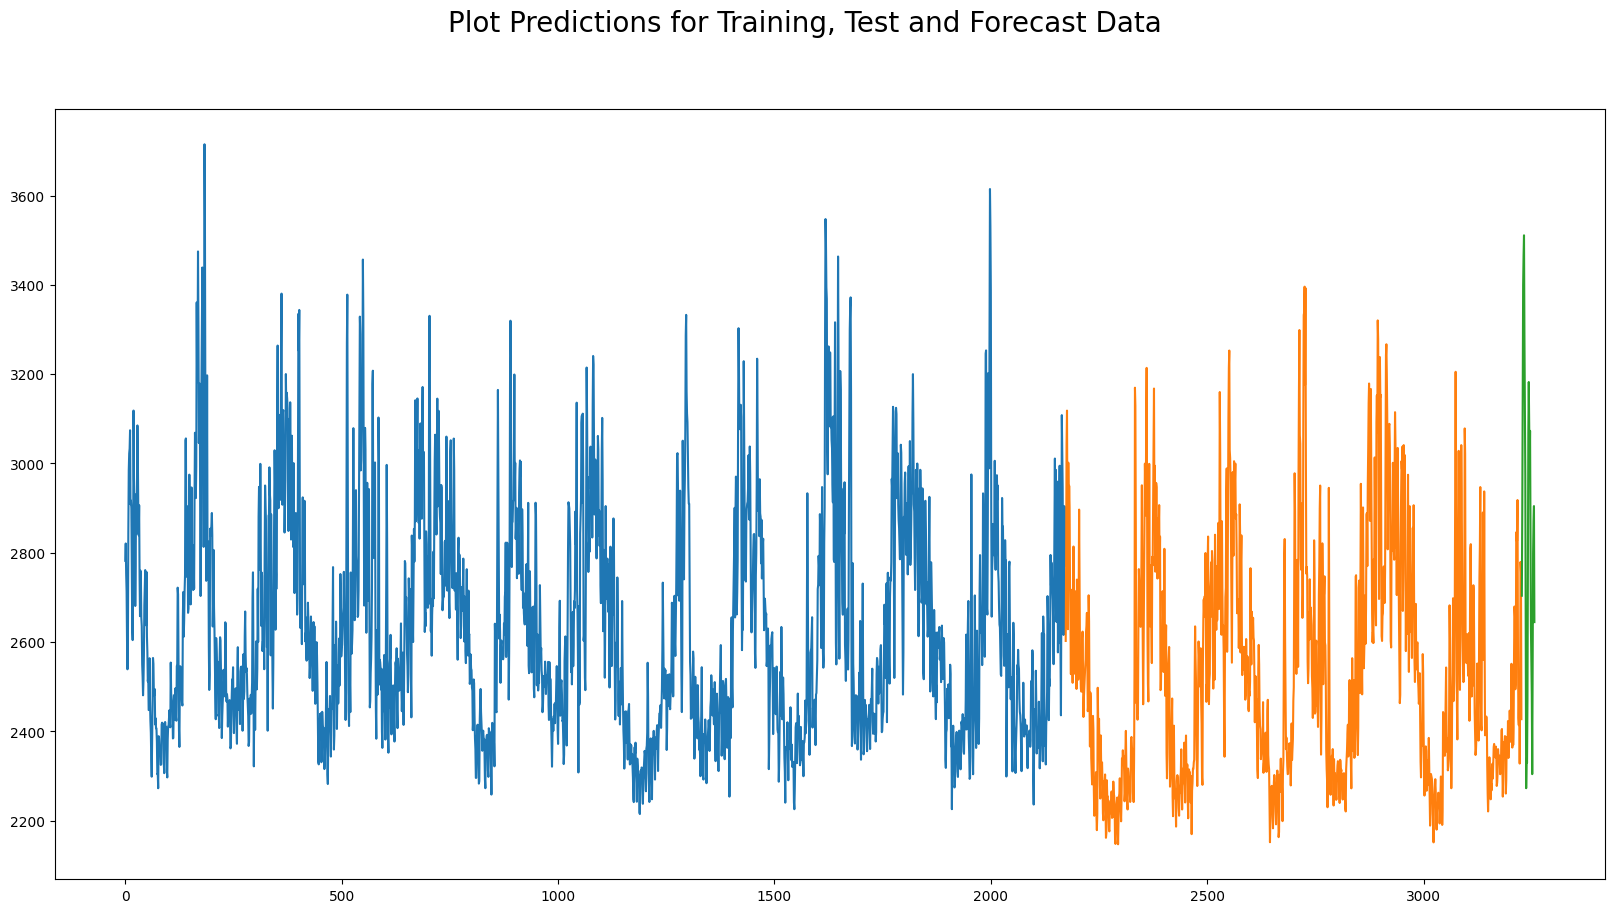

In [42]:
total_size=len(predict_on_train)+len(predict_on_test)+len(predict_on_future_month)

predict_train_plot=np.empty((total_size,1))
predict_train_plot[:,:]=np.nan
predict_train_plot[0:len(predict_on_train),:]=predict_on_train

predict_test_plot=np.empty((total_size,1))
predict_test_plot[:,:]=np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test),:]=predict_on_test

predict_future_plot=np.empty((total_size,1))
predict_future_plot[:,:]=np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size,:]=predict_on_future_month

plt.figure(figsize=(20, 10)).suptitle("Plot Predictions for Training, Test and Forecast Data", fontsize=20) 
plt.plot(predict_train_plot[::24])
plt.plot(predict_test_plot[::24])
plt.plot(predict_future_plot[::24])
plt.show()

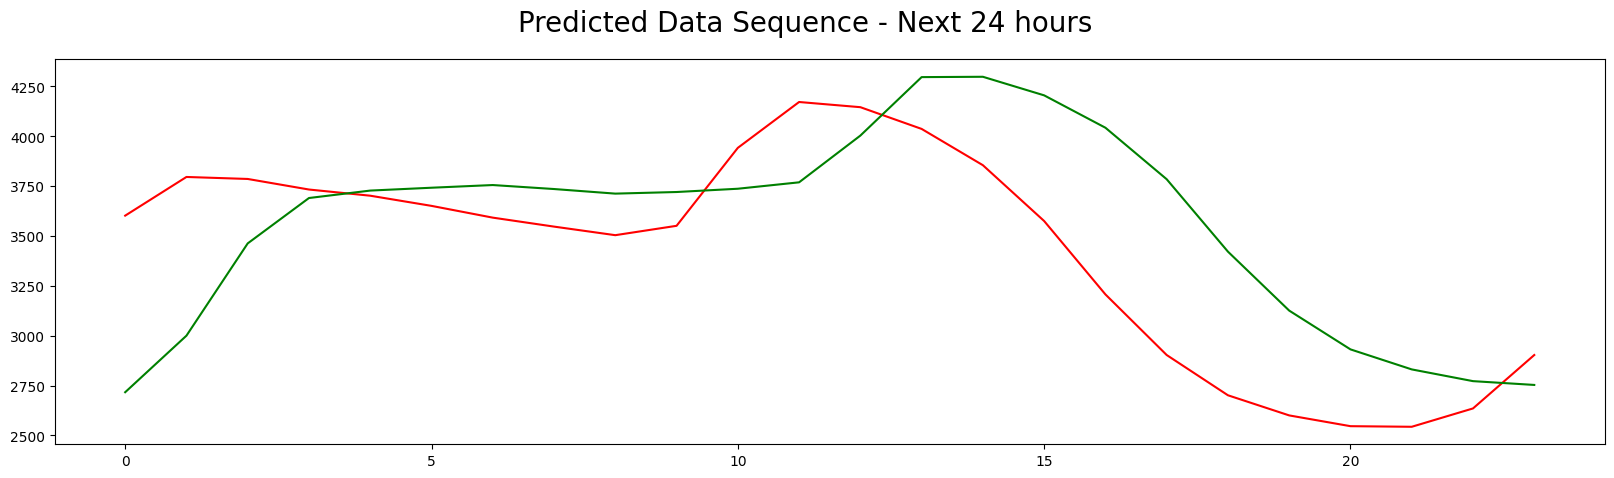

In [43]:
plt.figure(figsize=(20,5)).suptitle("Predicted Data Sequence - Next 24 hours",fontsize=20)
plt.plot(test_load[:24],color='r')
plt.plot(predict_on_future_day,color='g')
plt.show()

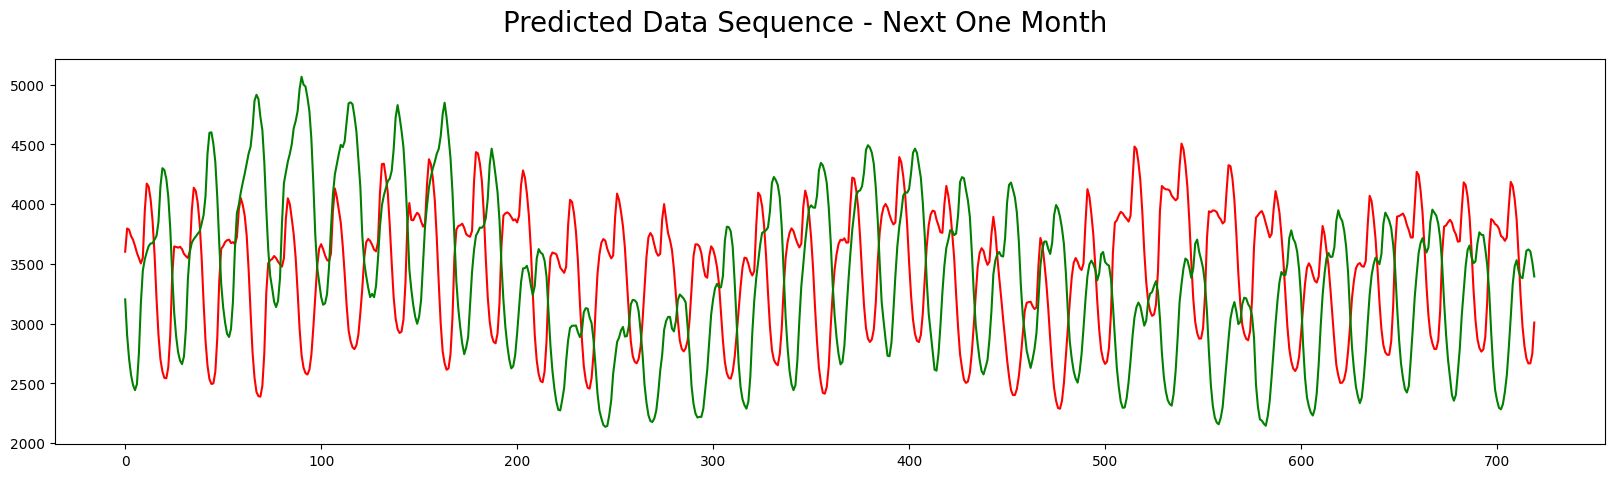

In [44]:
plt.figure(figsize=(20,5)).suptitle("Predicted Data Sequence - Next One Month",fontsize=20)
plt.plot(test_load[:720],color='r')
plt.plot(predict_on_future_month,color='g')
plt.show()

In [ ]:
# from datetime import datetime, timedelta
# def daterange(start_date, end_date):
#   delta=timedelta(hours=1)
#   while start_date<end_date:
#     yield start_date
#     start_date += delta

# predicted_dates=[]

# start_date=datetime(2013,12,31,00,00)
# end_date=datetime(2012,12,30,23,59)
# for single_date in daterange(start_date,end_date):
#   d=single_date.strftime("%Y-%m-%d %H:%M")
#   predicted_dates.append(d)

# y_values=predict_on_future[:25]
# fig,ax=plt.subplots(figsize=(20,5))

# ax.plot(y_values,color="purple")

# ax.set(xlabel="Date and Time",
#        ylabel="Requests",
#        title="Predicted next day hourly requests - TCS Server\n")
# day_points=[x for x in range(25)]
# plt.xticks(day_points,predicted_dates,rotation='vertical')

# plt.show()